# Homework 2 - EECS 600 Deep Learning

Name: Yida Liu

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer, tf.keras, etc.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 10/15/19 - midnight EST

100 Points Total

In [0]:
# For colab to upgrade matplotlib to 3.1.1
!pip install --upgrade matplotlib==3.1.1

Requirement already up-to-date: matplotlib==3.1.1 in /usr/local/lib/python3.6/dist-packages (3.1.1)


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm_notebook
import pandas as pd
import seaborn as sns
from numba import njit
%matplotlib inline
tf.enable_eager_execution()

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test = np.reshape(x_test, (x_test.shape[0], 28*28))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

Additionally, if you are having trouble getting autoencoders to fit with sigmoid hidden units, feel free to change them to ReLU units instead.

# Question 1
Implement an autoencoder that encodes MNIST images as a 64 dimensional representation. Your hidden layer should use sigmoid activation functions. Determine an appropriate learning rate and number of epochs to train your model. Use a minibatch size of 128.

In [0]:
class FcLayer:
    # A fully connected layer
    def __init__(self, num_input, num_output, activation_func):
        self.b = tf.Variable(
            tf.constant(0.1, shape=num_output)
        )
        self.W = tf.Variable(
            tf.truncated_normal(
                shape=(num_input, num_output),
                stddev=0.2
            )
        )
        self.activation_func = activation_func
        self.all_variables = [self.W, self.b]
    
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        return self.activation_func(tf.matmul(x, self.W) + self.b)

class OneHiddenLayerFcModel:
    # A model with one hidden layer
    def __init__(self, num_input : int, num_hidden : int, num_output : int,
                 hidden_activation=tf.nn.sigmoid, output_activation=tf.nn.sigmoid):
        self.hidden_layer = FcLayer(num_input, num_hidden, hidden_activation)
        self.output_layer = FcLayer(num_hidden, num_output, output_activation)
        self.all_layers = [self.hidden_layer, self.output_layer]
        
        self.all_variables = []
        self.all_weights = []
        for layer in reversed(self.all_layers):
            self.all_variables.extend(layer.all_variables)
            self.all_weights.append(layer.W)
        
    def encode(self, x):
        return self.hidden_layer.forward(x)
    
    def decode(self, c):
        return self.output_layer.forward(c)
    
    def forward(self, x):
        code = self.encode(x)
        return self.decode(code)
    
    def __call__(self, x):
        return self.forward(x)
    
    def backprop(self, inputs, outputs, stepper_func, loss_func, learning_rate):
        with tf.GradientTape() as t:
            current_loss = loss_func(self(inputs), outputs)
            d_all_variables = t.gradient(current_loss, self.all_variables)
        
        stepper_func(self.all_variables, d_all_variables, lr=learning_rate)
        
class OneHiddenLayerFcAutoencoder(OneHiddenLayerFcModel):
    
    def __init__(self, num_input : int, num_hidden : int,
                 hidden_activation=tf.nn.sigmoid, output_activation=tf.nn.sigmoid):
        super().__init__(num_input, num_hidden, num_input, hidden_activation, output_activation)
    
    def backprop(self, inputs, *arg, **kwargs):
        super().backprop(inputs, inputs, *arg, **kwargs)
        
def SGDStep(variables, gradients, lr):
    # performs SGD Step for given variables and gradient
    for V, dV in zip(variables, gradients):
        V.assign_sub(lr * dV)
        
def MeanSquareLoss(y, y_out):
    # Computes the mean-squared error of the true value y and output y from model
    return tf.reduce_mean(tf.squared_difference(y, y_out))

def train_autoencoder(model, stepper_func, loss_func,
                      x_train, y_train, x_test, y_test,
                      num_epochs, batch_size, learning_rate,
                      verbose=True, post_batch_action=lambda *args, **kwargs:None):
    # train an given autoencoder model
    __training_loss = []
    __testing_loss = []

    training_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))

    num_batches = len(x_train) // batch_size + 1

    __epoch_progress_bar = tqdm_notebook(
        range(1, num_epochs + 1),
        desc="Training", 
    )

    for epoch_idx in __epoch_progress_bar:
        __training_dataset = training_dataset.shuffle(10000).batch(batch_size)

        __batch_progress_bar = tqdm_notebook(__training_dataset,
                                             total=num_batches,
                                             desc="Epoch %d" % epoch_idx,
                                             disable=not verbose,
                                             )

        for X, _ in __batch_progress_bar:
            model.backprop(X, stepper_func, loss_func, learning_rate)

        __epoch_train_loss = loss_func(model(x_train), x_train)
        __epoch_test_loss = loss_func(model(x_test), x_test)

        __training_loss.append(__epoch_train_loss)
        __testing_loss.append(__epoch_test_loss)

        if verbose:
            __epoch_progress_bar.write("Training Loss: %5f" % __epoch_train_loss)
            __epoch_progress_bar.write("Testing Loss: %5f" % __epoch_test_loss)
        
        post_batch_action()

    return __training_loss, __testing_loss

def plot_loss_by_epoch(trloss, tstloss, title=None, dpi=90, figsize=(5,5)):

    __figure = plt.figure(dpi=dpi, figsize=figsize)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    __num_epochs = len(trloss)
    plt.xlim([-1, __num_epochs])
    plt.xticks(range(-1, __num_epochs+1))
    __train_line, *_ = plt.plot(trloss, "-o")
    __test_line,*_ = plt.plot(tstloss, "-o")

    plt.legend([__train_line, __test_line], ["train", "test"])

def plot_random_reconstruct(model, test_x, test_y, size, dpi=70, figsize=(10, 10)):
    fig, axs = plt.subplots(*size, dpi=90, figsize=(20, 20))
    img_idxs = np.random.randint(0, len(test_x), size=size).flatten()
    imgs = np.reshape(model(test_x[img_idxs]), (-1, 28, 28))
    labels = test_y[img_idxs]

    for picax, idx, img, label in zip(axs.flat, img_idxs, imgs, labels):
        picax.set_title("Image %d Label %d" % (idx, label))
        picax.imshow(img, cmap=plt.cm.gray)
        picax.set_frame_on(False)
        picax.set_axis_off()
    
    plt.tight_layout()

In [0]:
q1p1_model = OneHiddenLayerFcAutoencoder(784, 64)

learning_rate = 90
num_epoch = 25
batch_size = 128

q1p1_losses = train_autoencoder(q1p1_model, SGDStep, MeanSquareLoss,
                              x_train, y_train, x_test, y_test,
                              num_epochs=num_epoch,
                              batch_size=batch_size,
                              learning_rate=learning_rate)

Training Loss: 0.033271
Testing Loss: 0.032947


Training Loss: 0.024757
Testing Loss: 0.024423


Training Loss: 0.020330
Testing Loss: 0.019984


Training Loss: 0.017689
Testing Loss: 0.017360


Training Loss: 0.015953
Testing Loss: 0.015641


Training Loss: 0.014670
Testing Loss: 0.014363


Training Loss: 0.013673
Testing Loss: 0.013382


Training Loss: 0.012910
Testing Loss: 0.012631


Training Loss: 0.012241
Testing Loss: 0.011972


Training Loss: 0.011726
Testing Loss: 0.011467


Training Loss: 0.011394
Testing Loss: 0.011142


Training Loss: 0.010816
Testing Loss: 0.010578


Training Loss: 0.010721
Testing Loss: 0.010495


Training Loss: 0.010196
Testing Loss: 0.009968


Training Loss: 0.010311
Testing Loss: 0.010083


Training Loss: 0.009915
Testing Loss: 0.009714


Training Loss: 0.009805
Testing Loss: 0.009602


Training Loss: 0.009979
Testing Loss: 0.009789


Training Loss: 0.009139
Testing Loss: 0.008948


Training Loss: 0.009065
Testing Loss: 0.008884


Training Loss: 0.008790
Testing Loss: 0.008598


Training Loss: 0.008848
Testing Loss: 0.008679


Training Loss: 0.008603
Testing Loss: 0.008431


Training Loss: 0.009093
Testing Loss: 0.008938


Training Loss: 0.009011
Testing Loss: 0.008863



Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib.

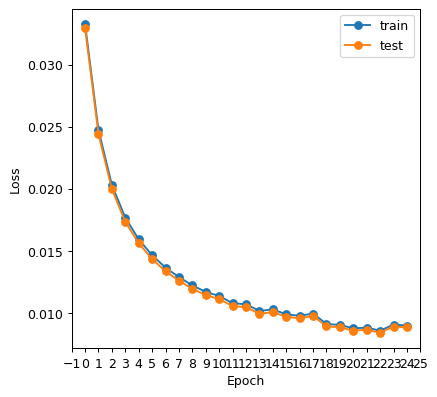

In [0]:
plot_loss_by_epoch(*q1p1_losses)

Plot a 10x10 image of reconstructred random examples from your testing set.

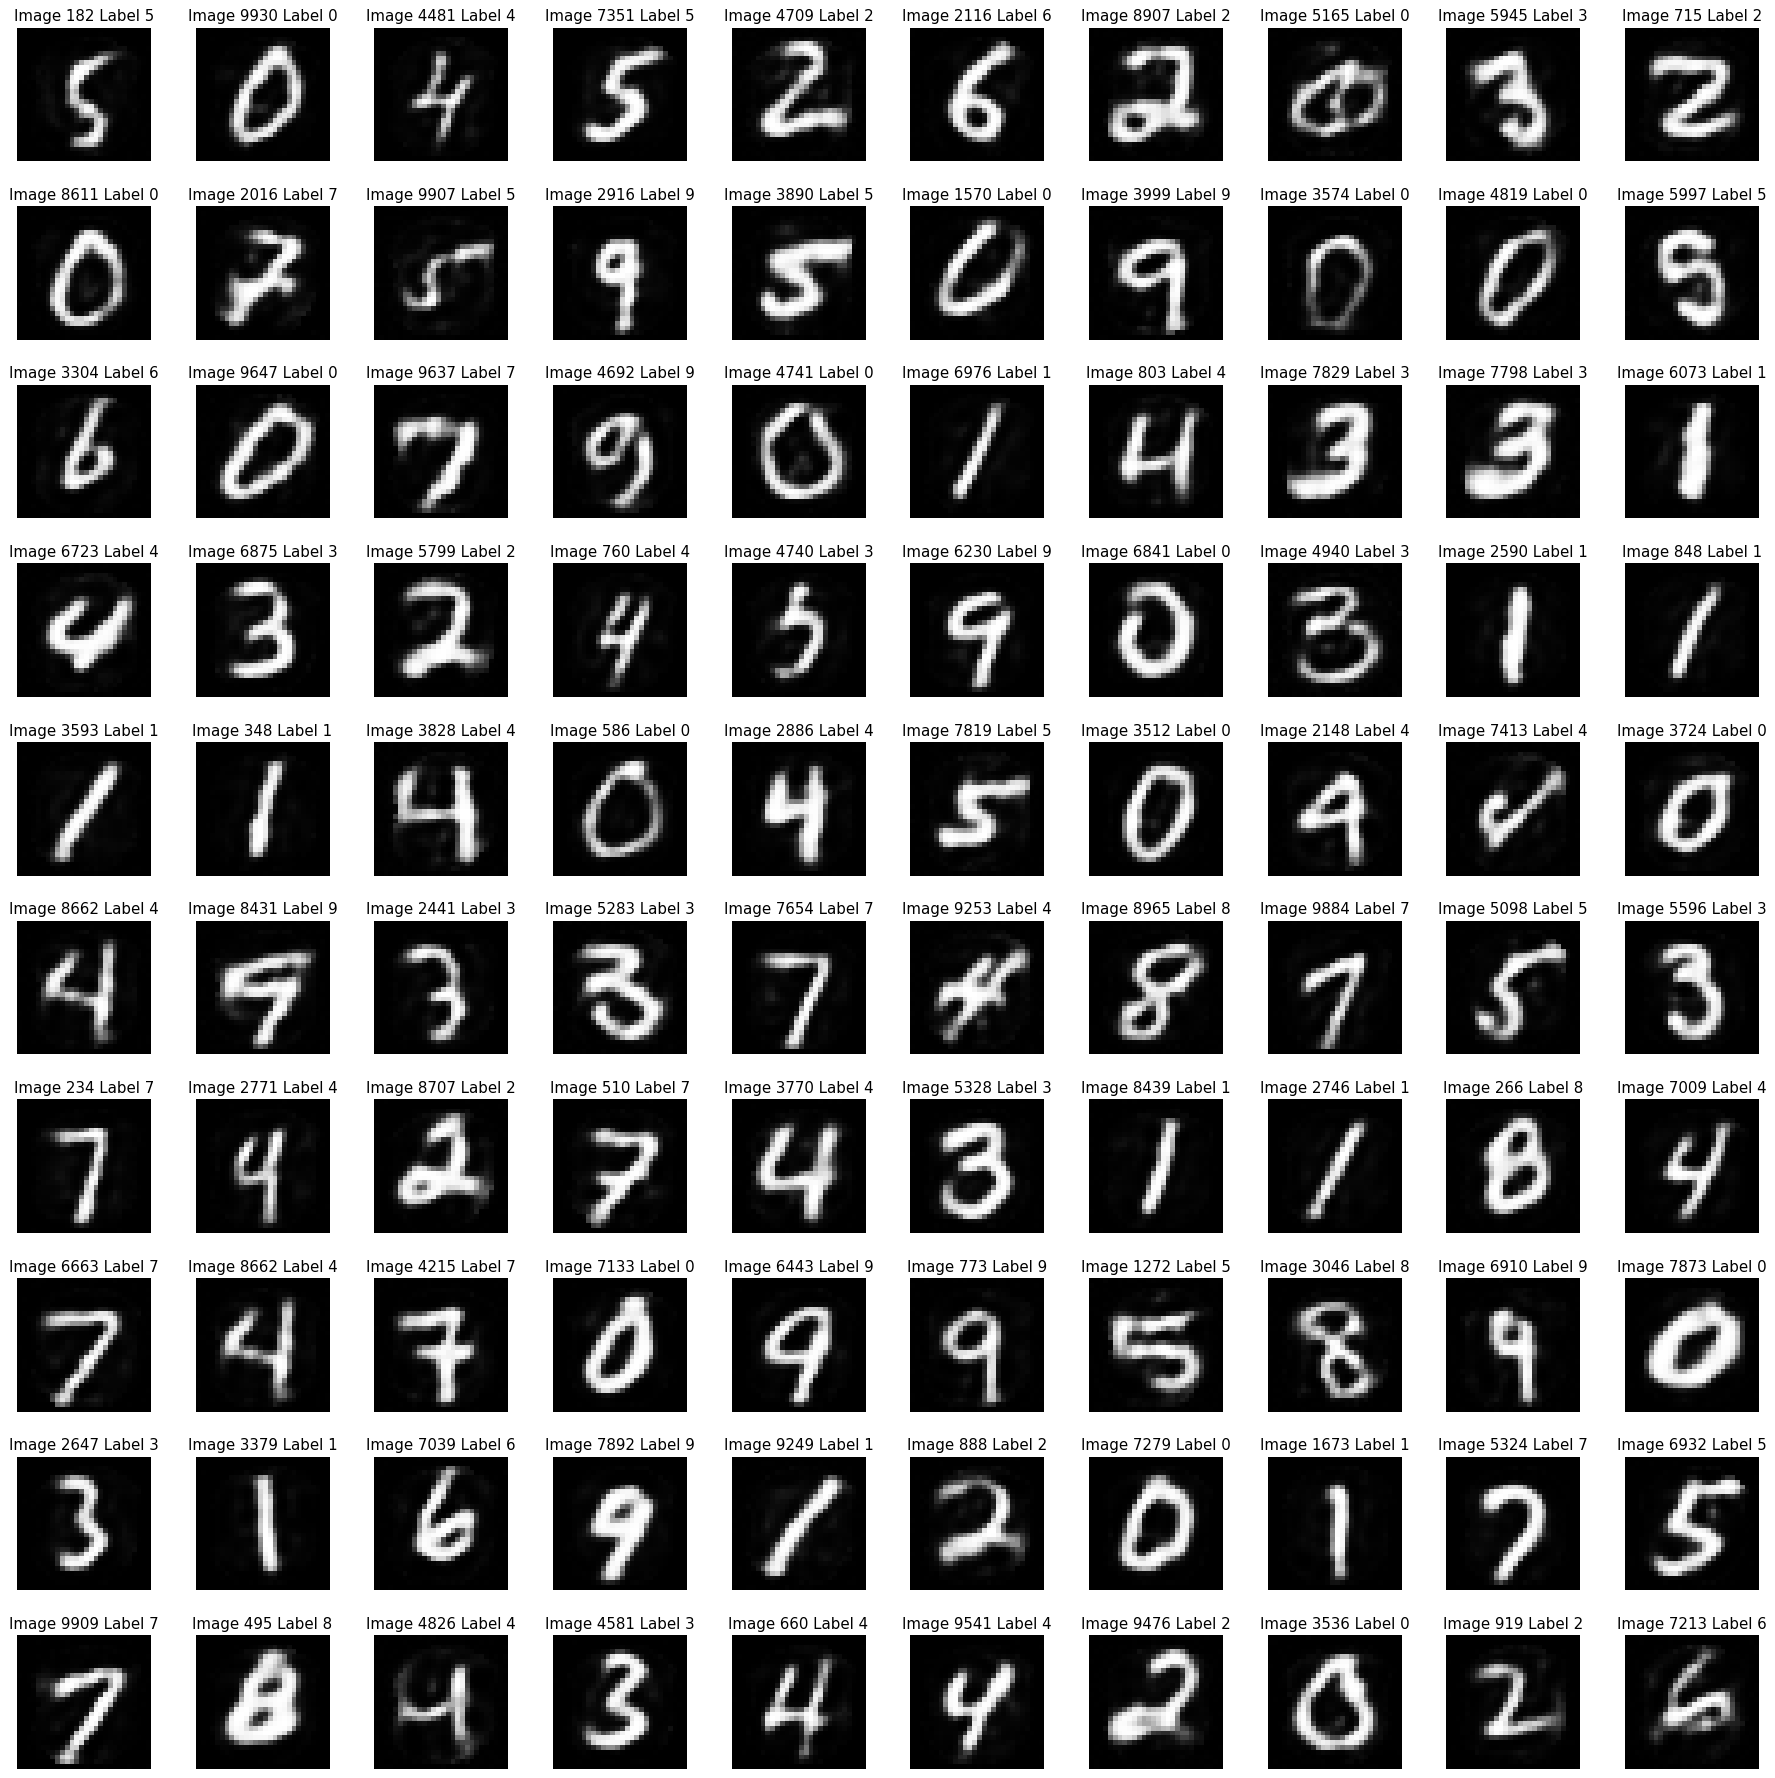

In [0]:
plot_random_reconstruct(q1p1_model, x_test, y_test, (10,10), figsize=(6,6))

How did you determine the appropriate learning rate and number of epochs for training?

We followed a trial-and-update approach to find the optimal learning rate and number of epochs and found that one optimal combination is $\text{Learning Rate} : 90, \text{Num Epoch}: 25$.

We also conducted a randomized search in the linear space of learning rate and number of epochs to find the value that minimizes the loss. However, <u>this process is unpleasantly slow, therefore, not suggested</u>. We also conducted research on multiple "auto-tuning" software package for deep learning modules. They are `ray | tune`, `HParam` from `tensorflow`, and `nni` from Microsoft. Most of the existing tools combines intelligent pruning and parallel architecture to speed up the process. 

## Question 1 Part 2
Add an $L_1$ regularization weight term to your loss function only on the weights to your encoder. Your new loss function should be $L(X) = \sum_i(X_i - decode(encode(X_i)))^2 + \alpha\sum_j|W_j|$ where $X$ is a minibatch of your data. Determine an appropriate value of $\alpha$. If you are having trouble getting started, consider values in powers of 10, i.e. $\alpha = 10^-5, 10^-4, 10^-3, ..., 10^1, 10^2, 10^3$.

In [0]:
# Q1P2 Regularized SD
class L2RegularizedSquareDiffLoss:
    
    def __init__(self, beta, model):
        self.beta = beta
        self.Ws = model.all_weights
    
    def l2reg(self):
        return tf.add_n([tf.nn.l2_loss(W) for W in self.Ws])

    def __call__(self, y, y_out):
        mseloss = tf.reduce_mean(tf.squared_difference(y, y_out))
        l2reg = self.l2reg()
        return tf.reduce_mean(mseloss + self.beta * l2reg)

In [0]:
q1p2_model = OneHiddenLayerFcAutoencoder(784, 64)

learning_rate = 50
num_epoch = 50
batch_size = 300

q1p2_regularized_squared_error_loss_func = L2RegularizedSquareDiffLoss(10**-5, q1p2_model)
q1p2_l2regs = []

q1p2_losses = train_autoencoder(q1p2_model, SGDStep, q1p2_regularized_squared_error_loss_func,
                                x_train, y_train, x_test, y_test,
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate,
                                post_batch_action=lambda *args, **kwargs: 
                                        q1p2_l2regs.append(q1p2_regularized_squared_error_loss_func.l2reg()),
                                verbose=False # Too many epochs
                                )

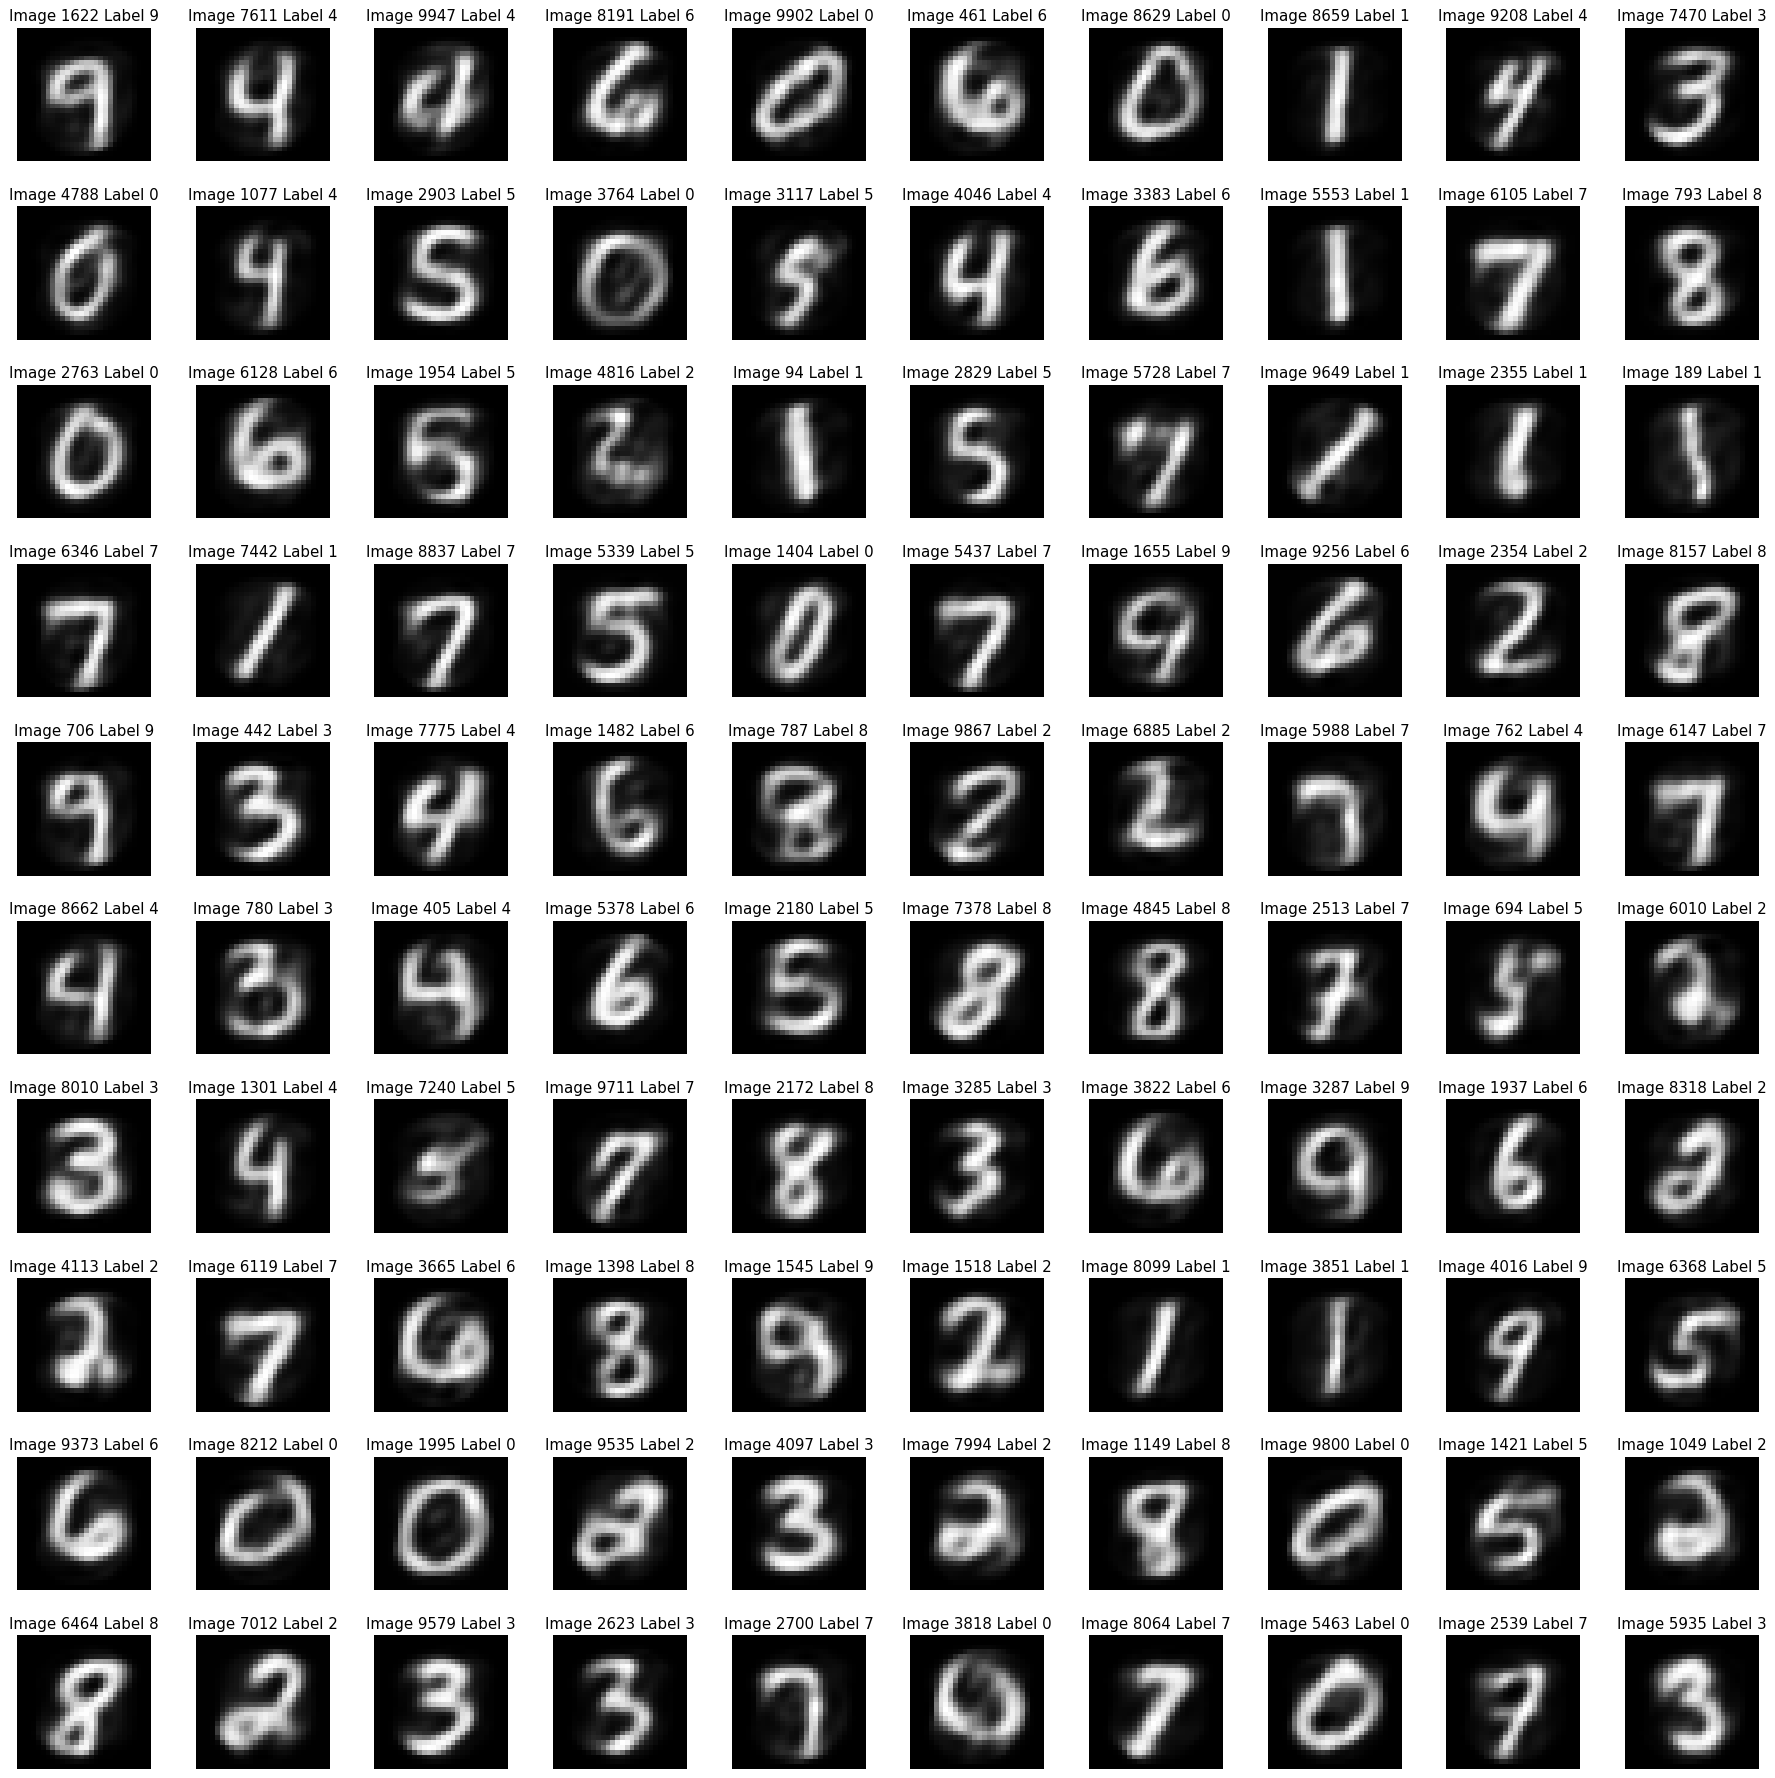

In [0]:
plot_random_reconstruct(q1p2_model, x_test, y_test, (10,10), figsize=(6,6))

Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib. Additionally, plot the weight regularization value at each epoch ($\sum_j|W_j|$).

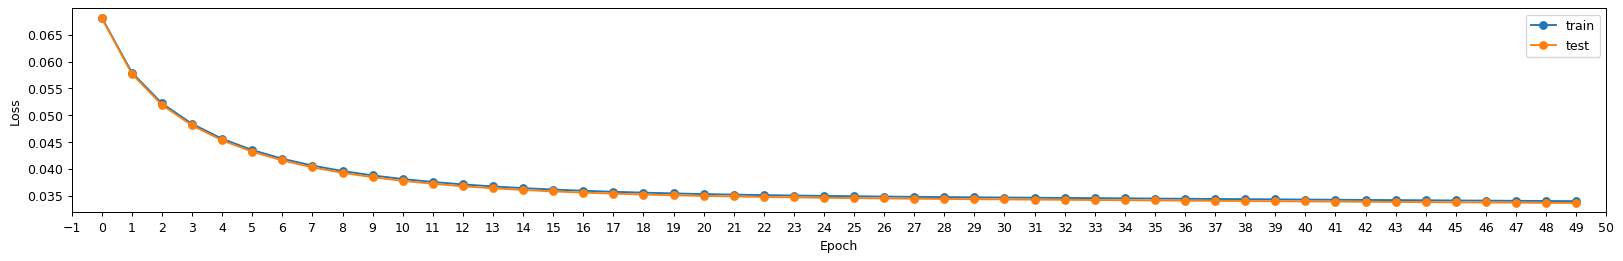

In [0]:
plot_loss_by_epoch(*q1p2_losses, figsize=(22, 3))

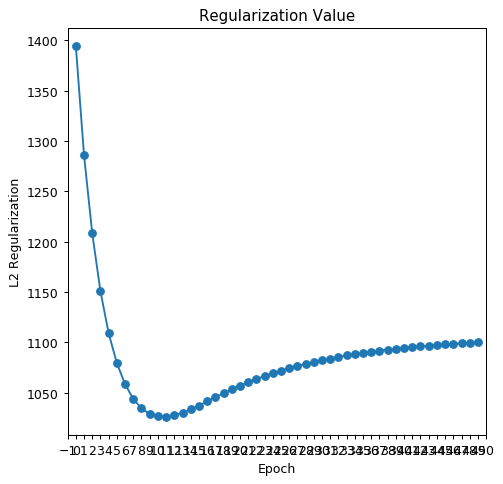

In [0]:
__figure = plt.figure(dpi=90, figsize=(6,6))
plt.title("Regularization Value")
plt.xlabel("Epoch")
plt.ylabel("L2 Regularization")

__num_epochs = len(q1p2_l2regs)
plt.xlim([-1, __num_epochs])
plt.xticks(range(-1, __num_epochs+1))
plt.plot(q1p2_l2regs, "-o")

How did you determine the appropriate weight regularization parameter?

We follow a trial-and-error apporach to determine a weight regularization parameter. 

## Question 2 Part 1

One of the [first papers](https://www.cs.toronto.edu/~hinton/science.pdf) in the deep learning literature proposed greedy layer wise training of deep neural networks. A greedy deep autoencoder first trains the first autoencoder, uses the representation to train the second autoencoder, etc. Train a greedy deep network for the MNIST data with the following layer sizes 400 - 200 - 50 - 10 - 2. Train on a random sample of 20000 MNIST rows. Use sigmoid activation layers and determine an appropriate learning rate.

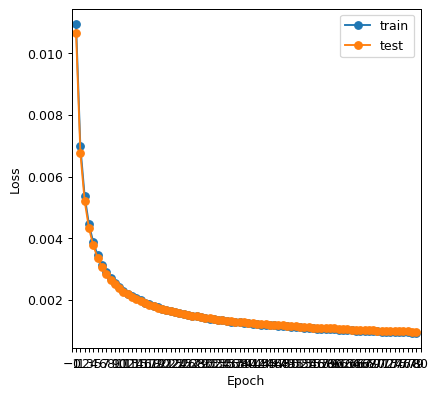

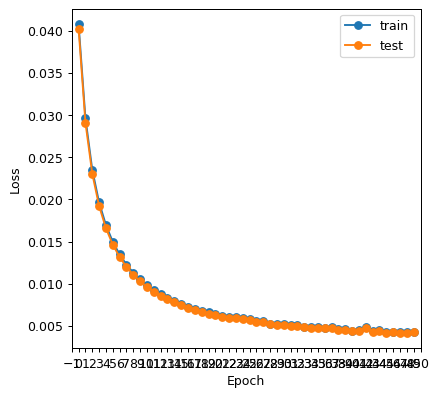

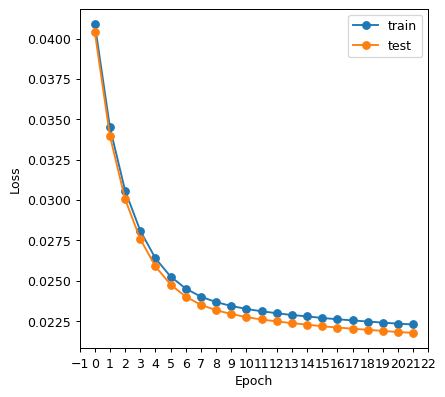

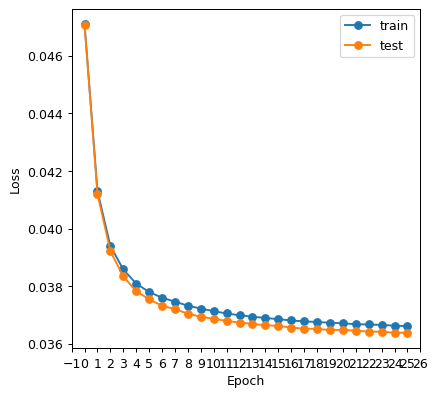

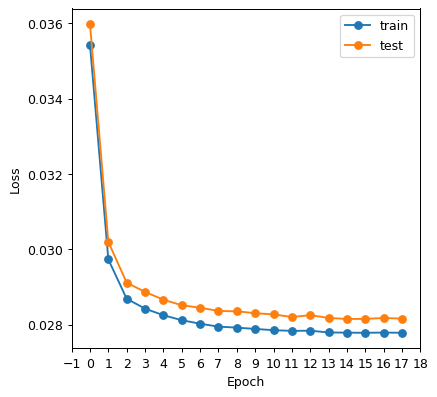

In [0]:
q2p1_all_code_sizes = [400, 200, 50, 10, 2]
q2p1_all_code_configs = [
    {
        "lr": 120,
        "num_epoch": 80,
    },
    {
        "lr": 28,
        "num_epoch": 50,
    },
    {
        "lr": 30,
        "num_epoch": 22,
    },
    {
        "lr": 18,
        "num_epoch": 26,
    },
    {
        "lr": 8,
        "num_epoch": 18,
    }
]

# Execution of greedy deep autoencoder
q2p1_all_models = []
q2p1_all_losses = []

batch_size = 128

last_code_size = 784

__x_train = x_train
__x_test = x_test

__all_x_trains = []
__all_x_tests = []

for code_size, config in tqdm_notebook(
    zip(q2p1_all_code_sizes, q2p1_all_code_configs),
    total=len(q2p1_all_code_sizes),
    desc="Greedy Autoencoder"
):
    __current_model = OneHiddenLayerFcAutoencoder(last_code_size, code_size)
    __current_losses = train_autoencoder(__current_model, SGDStep, MeanSquareLoss,
                                         __x_train, y_train, __x_test, y_test,   # wont use y
                                         num_epochs=config["num_epoch"],
                                         batch_size=batch_size,
                                         learning_rate=config["lr"],
                                         verbose=False)
    plot_loss_by_epoch(*__current_losses)
    q2p1_all_models.append(__current_model)
    q2p1_all_losses.append(__current_losses)
    __x_train = __current_model.encode(__x_train)
    __x_test = __current_model.encode(__x_test)
    __all_x_trains.append(__x_train)
    __all_x_tests.append(__x_test)

    last_code_size = code_size

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

In [0]:
# prepare data
__x_train = x_train
__x_test = x_test
for i in tqdm_notebook(range(len(q2p1_all_models) - 1)):
    __x_train = q2p1_all_models[i].encode(__x_train)
    __x_test  = q2p1_all_models[i].encode(__x_test)
    
# model for 2-label
label_models = q2p1_all_models[-1]
__q2p1_x_test = label_models.encode(__x_test)

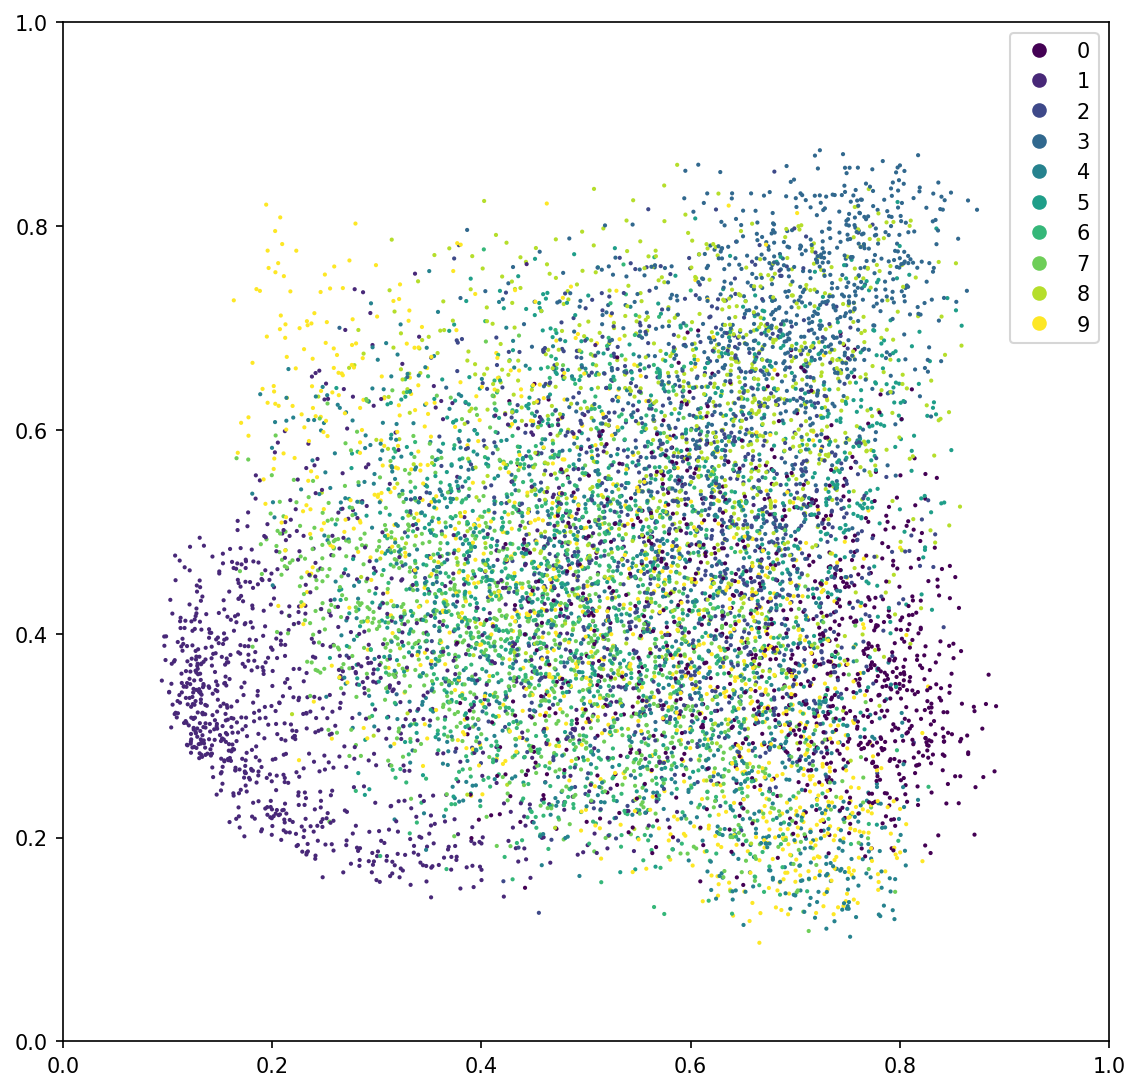

In [0]:
fig = plt.figure(dpi=150, figsize=(9,9))

scatter = plt.scatter(*tf.transpose(__q2p1_x_test), c=y_test, s=1)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])

plt.legend(*scatter.legend_elements())

## Question 2 Part 2
Instead of training a multi-layer deep architecture, train just one layer of size 2. Once again use sigmoid activation functions and determine an appropriate learning rate.

Training Loss: 0.070524
Testing Loss: 0.070784


Training Loss: 0.068646
Testing Loss: 0.068891


Training Loss: 0.068112
Testing Loss: 0.068347


Training Loss: 0.067867
Testing Loss: 0.068098


Training Loss: 0.067729
Testing Loss: 0.067964


Training Loss: 0.067637
Testing Loss: 0.067873


Training Loss: 0.067577
Testing Loss: 0.067809


Training Loss: 0.067532
Testing Loss: 0.067768


Training Loss: 0.067498
Testing Loss: 0.067730


Training Loss: 0.067469
Testing Loss: 0.067699


Training Loss: 0.067447
Testing Loss: 0.067671


Training Loss: 0.067430
Testing Loss: 0.067661


Training Loss: 0.067415
Testing Loss: 0.067644


Training Loss: 0.067402
Testing Loss: 0.067631


Training Loss: 0.067390
Testing Loss: 0.067620


Training Loss: 0.067381
Testing Loss: 0.067606


Training Loss: 0.067373
Testing Loss: 0.067601


Training Loss: 0.067366
Testing Loss: 0.067595


Training Loss: 0.067360
Testing Loss: 0.067589


Training Loss: 0.067354
Testing Loss: 0.067582


Training Loss: 0.067348
Testing Loss: 0.067578


Training Loss: 0.067344
Testing Loss: 0.067568


Training Loss: 0.067341
Testing Loss: 0.067576


Training Loss: 0.067336
Testing Loss: 0.067560


Training Loss: 0.067333
Testing Loss: 0.067561


Training Loss: 0.067330
Testing Loss: 0.067557


Training Loss: 0.067327
Testing Loss: 0.067558



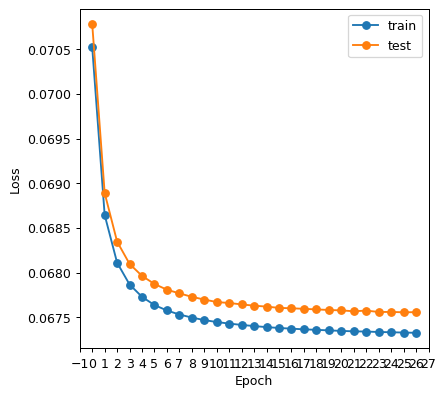

In [0]:
q2p2_model = OneHiddenLayerFcAutoencoder(784, 2)

learning_rate = 30
num_epoch = 27
batch_size = 128

q2p2_losses = train_autoencoder(q2p2_model, SGDStep, MeanSquareLoss,
                                x_train, y_train, x_test, y_test,
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate)
plot_loss_by_epoch(*q2p2_losses)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

In [0]:
__q2p2_x_test = q2p2_model.encode(x_test)

__q2p2_x_test.shape

TensorShape([Dimension(10000), Dimension(2)])

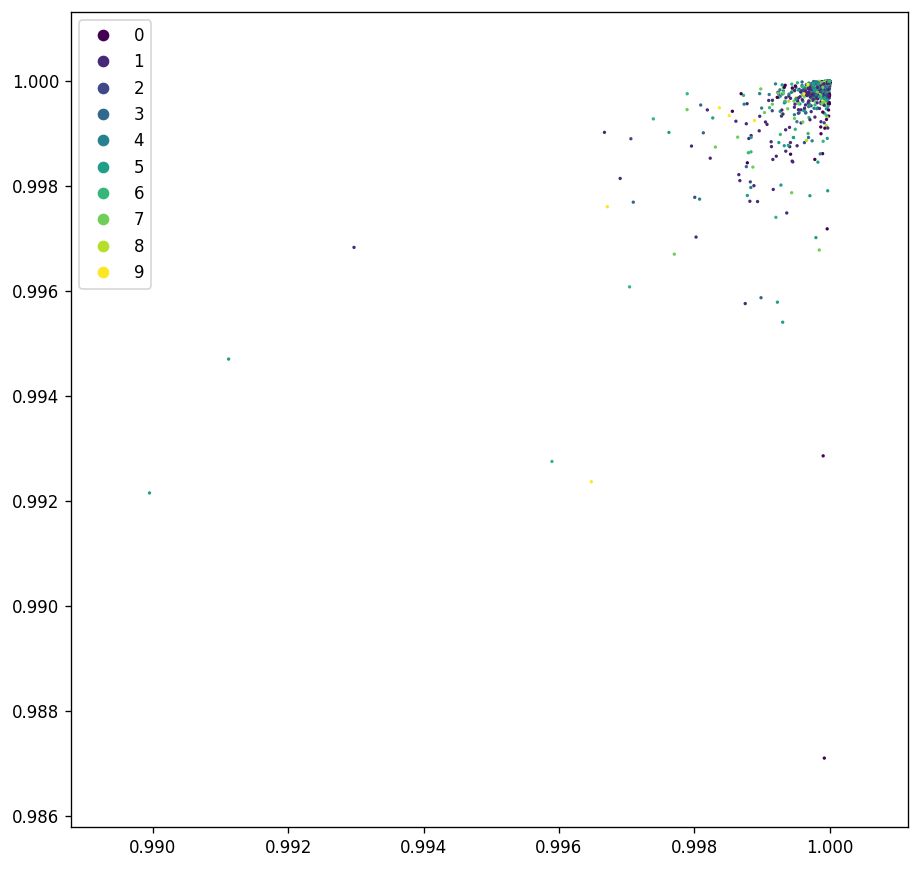

In [0]:
fig = plt.figure(dpi=120, figsize=(9,9))

scatter = plt.scatter(*tf.transpose(__q2p2_x_test), c=y_test, s=1)

plt.legend(*scatter.legend_elements())

## Question 2 Part 3
Train a standard feed-forward neural network with one hidden layer of size two and sigmoid activation functions for predicting which digit each of the training samples is from.

In [0]:
# Modified from Homework 1

def train_nn(model, stepper_func, loss_func, acc_func,
                      x_train, y_train, x_test, y_test,
                      num_epochs, batch_size, learning_rate,
                      verbose=True):
    __training_loss = []
    __testing_loss = []
    __training_accuracy = []
    __testing_accuracy = []

    training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    num_batches = len(x_train) // batch_size + 1

    __epoch_progress_bar = tqdm_notebook(
        range(1, num_epochs + 1),
        desc="Training", 
        disable=not verbose
    )

    for epoch_idx in __epoch_progress_bar:

        # Train on the whole dataset
        __training_dataset = training_dataset.shuffle(10000).batch(batch_size)
        __batch_progress_bar = tqdm_notebook(__training_dataset,
                                             total=num_batches,
                                             desc="Epoch %d" % epoch_idx,
                                             disable=not verbose,
                                             )
        for X, y in __batch_progress_bar:
            model.backprop(X, y, stepper_func, loss_func, learning_rate)

        # Compute loss and accuracy
        __epoch_train_loss = loss_func(model(x_train), y_train)
        __epoch_test_loss = loss_func(model(x_test), y_test)

        __epoch_train_accuracy = acc_func(model(x_train), y_train)
        __epoch_test_accuracy = acc_func(model(x_test), y_test)

        __training_loss.append(__epoch_train_loss)
        __training_accuracy.append(__epoch_train_accuracy)

        __testing_loss.append(__epoch_test_loss)
        __testing_accuracy.append(__epoch_test_accuracy)

        if verbose:
            __epoch_progress_bar.write("Test loss: %5f" % __epoch_test_loss)
            __epoch_progress_bar.write(
                "Test accuracy: %f" % __epoch_test_accuracy)

    return __training_loss, __training_accuracy, __testing_loss, __testing_accuracy

def prob_accuracy(y_out_hat, y_out):
    """
    The validation accuracy given the predict value and ground truth

    Observed that the output of neural network is a vector of probability of each label,
    we take the `argmax` of the probability vector to convert to labels
    """
    y_hat = tf.math.argmax(y_out_hat, axis=1)
    y = tf.math.argmax(y_out, axis=1)

    eq = tf.math.equal(y_hat, y)
    nnz = tf.count_nonzero(eq)
    return nnz / y.shape[0]

def plot_loss_acc_by_epoch(trloss, tracc, tstloss, tstacc, dpi=80, figsize=[13, 5.3]):
    fig, axs = plt.subplots(1, 2, sharex=True, dpi=dpi, figsize=figsize)
    __num_epochs = len(trloss)

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlim([-1, __num_epochs])
    axs[0].set_xticks(range(-1, __num_epochs + 1))
    __train_line, *_ = axs[0].plot(trloss, "-o")
    __test_line, *_ = axs[0].plot(tstloss, "-o")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim([0, 1])
    axs[1].plot(tracc, "-o")
    axs[1].plot(tstacc, "-o")

    plt.legend([__train_line, __test_line], ["train", "test"])

In [0]:
q2p3_model = OneHiddenLayerFcModel(784, 2, 10, output_activation=tf.nn.softmax)

learning_rate = 30
num_epoch = 27
batch_size = 128

q2p3_losses = train_nn(q2p3_model, SGDStep, MeanSquareLoss, prob_accuracy,
                                x_train, tf.one_hot(y_train, 10), x_test, tf.one_hot(y_test, 10),
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate)

Test loss: 0.064655
Test accuracy: 0.451200


Test loss: 0.066115
Test accuracy: 0.414400


Test loss: 0.061106
Test accuracy: 0.497300


Test loss: 0.060960
Test accuracy: 0.492400


Test loss: 0.067776
Test accuracy: 0.447600


Test loss: 0.068722
Test accuracy: 0.396200


Test loss: 0.061908
Test accuracy: 0.478300


Test loss: 0.060927
Test accuracy: 0.494900


Test loss: 0.061350
Test accuracy: 0.473400


Test loss: 0.061294
Test accuracy: 0.503800


Test loss: 0.066186
Test accuracy: 0.419400


Test loss: 0.064069
Test accuracy: 0.444100


Test loss: 0.059782
Test accuracy: 0.497500


Test loss: 0.068978
Test accuracy: 0.400000


Test loss: 0.058929
Test accuracy: 0.509700


Test loss: 0.066420
Test accuracy: 0.455600


Test loss: 0.059856
Test accuracy: 0.501600


Test loss: 0.058786
Test accuracy: 0.505400


Test loss: 0.062106
Test accuracy: 0.495100


Test loss: 0.063030
Test accuracy: 0.465400


Test loss: 0.057901
Test accuracy: 0.527900


Test loss: 0.061536
Test accuracy: 0.480300


Test loss: 0.060588
Test accuracy: 0.491900


Test loss: 0.059360
Test accuracy: 0.520100


Test loss: 0.059628
Test accuracy: 0.491900


Test loss: 0.058004
Test accuracy: 0.528200


Test loss: 0.063788
Test accuracy: 0.470800



Pot the loss function and accuracy of your model

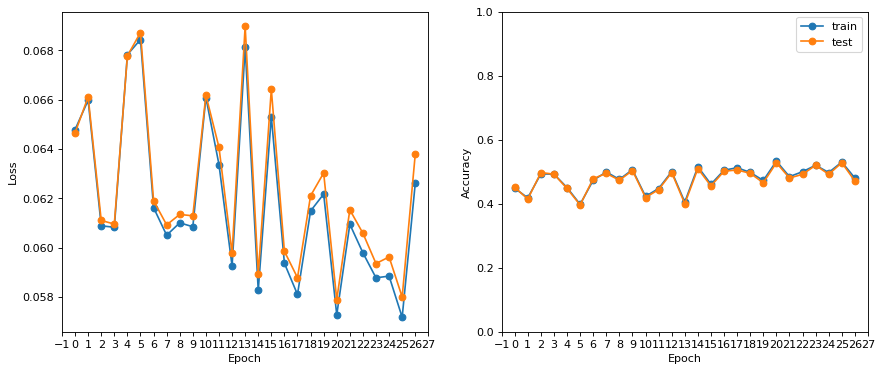

In [0]:
plot_loss_acc_by_epoch(*q2p3_losses)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

In [0]:
__q2p3_x_test = q2p3_model.encode(x_test)

__q2p3_x_test.shape

TensorShape([Dimension(10000), Dimension(2)])

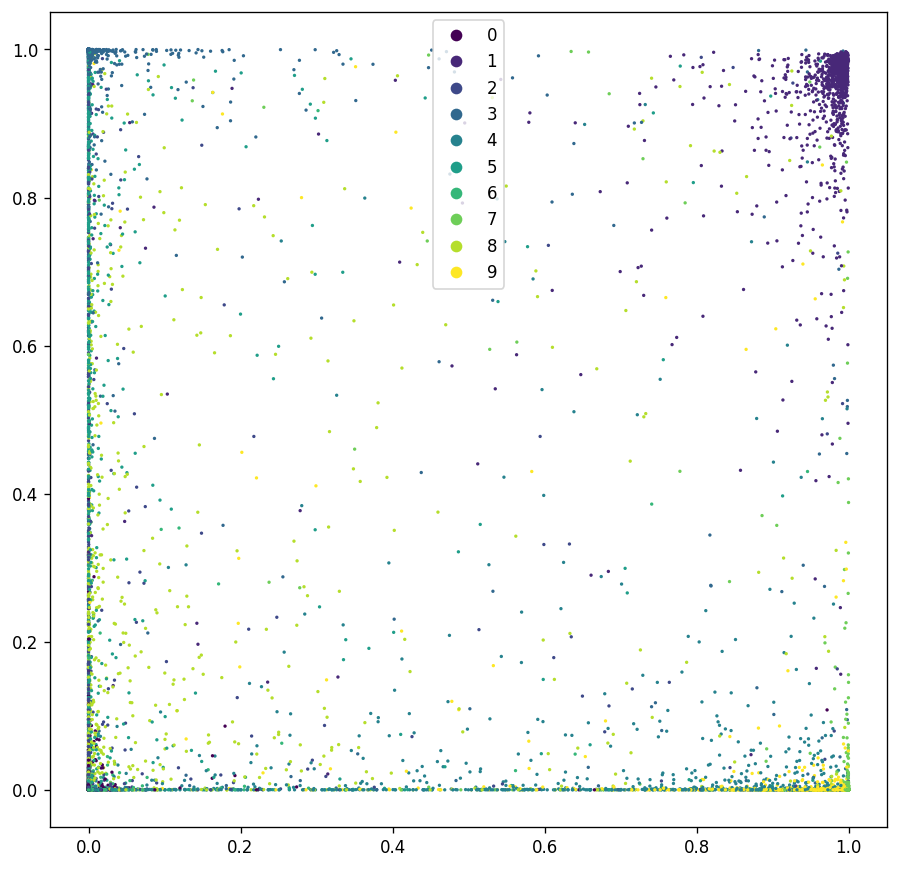

In [0]:
fig = plt.figure(dpi=120, figsize=(9,9))

scatter = plt.scatter(*tf.transpose(__q2p3_x_test), c=y_test, s=1)

plt.legend(*scatter.legend_elements())

## Question 2 Part 4
How different are the representations that the different approaches learned? What might make them different?

# Question 3 Part 1
Build a denoising autoencoder for the MNIST data. On each batch, add random [normal gaussian noise](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) to the inputs and then [clip the values](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) such that they are between 0 and 1. Evaluate the following mean and standard deviation values for the noise.

| Mean  | Standard Deviation |
|-------|--------------------|
| (loc) | (scale)            |
| 0.0   | 0.05               |
| 0.1   | 0.05               |
| 0.0   | 0.2                |
| 0.1   | 0.2                |

Your evaluation should compare the reconstruction error on the testing data with no added error. Use sigmoid activation functions with 64 hidden units.

In [0]:
class OneHiddenLayerFcDenoiseAutoencoder(OneHiddenLayerFcModel):
    
    def __init__(self, num_input : int, num_hidden : int, noise_func, *args, 
                 train_on_original=False, **kwargs):
        super().__init__(num_input, num_hidden, num_input, *args, **kwargs)
        self.noise_func = noise_func
        self.train_on_original=train_on_original
    
    def backprop(self, inputs, *arg, **kwargs):
        super().backprop(self.noise_func(inputs), inputs, *arg, **kwargs)
        if self.train_on_original:
            super().backprop(inputs, inputs, *arg, **kwargs)

def gaussian_noise_func(loc, scale):
    def __wrapper(x):
        noise = tf.random.normal(x.shape, loc, scale)
        return tf.clip_by_value(x + noise, 0, 1)
    return __wrapper

In [0]:
__q3p1_gaussian_params = [(0.0, 0.05), (0.1, 0.05), (0.0, 0.2), (0.1, 0.2)]
__q3p1_model_params = []
for gp in __q3p1_gaussian_params:
    __q3p1_model_params.append(gp)
__q3p1_hyperparams = [(40, 27), (40, 27), (40, 27), (40, 27)]

# Model running
batch_size=128
__q3p1_models = []
__q3p1_losses = []
for gparam, (lr, epoch) in tqdm_notebook(
                                zip(__q3p1_model_params, __q3p1_hyperparams), 
                                total=len(__q3p1_model_params),
                                desc="Training Denoise Autoencoders"):
    __noise_func = gaussian_noise_func(*gparam)
    __q3p1_model = OneHiddenLayerFcDenoiseAutoencoder(784, 64, __noise_func)
    __q3p1_loss = train_autoencoder(__q3p1_model, SGDStep, MeanSquareLoss,
                                    x_train, y_train, x_test, y_test,
                                    num_epochs=epoch,
                                    batch_size=batch_size,
                                    learning_rate=lr,
                                    verbose=False)
    __q3p1_models.append(__q3p1_model)
    __q3p1_losses.append(__q3p1_loss)

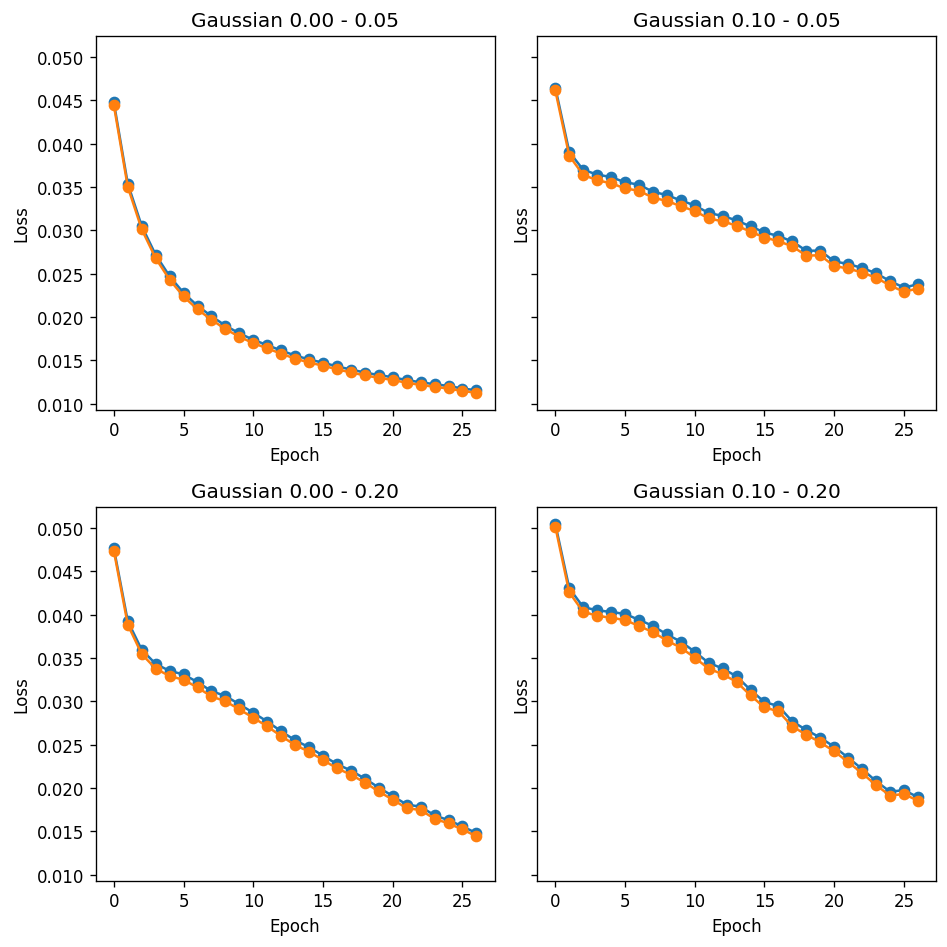

In [0]:
fig, axs = plt.subplots(2, 2, sharey='all', dpi=120, figsize=(8, 8))

for ax, losses, (p1, p2) in zip(axs.flat, __q3p1_losses, __q3p1_model_params):
    ax.set_title("Gaussian %.2f - %.2f" % (p1, p2))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.plot(losses[0], "-o")
    ax.plot(losses[1], "-o")

fig.tight_layout()

## Question 3 Part 2
Choose one of the denoising autencoders from the previous step. Use the hidden representation to train a model to predict the number present in the image.

Plot the training and testing accuracy for each epoch during training.

In [0]:
model = __q3p1_models[1]
__q3p2_x_train = model.encode(x_train)
__q3p2_x_test  = model.encode(x_test)

__q3p2_x_train.shape, __q3p2_x_test.shape

(TensorShape([Dimension(60000), Dimension(64)]),
 TensorShape([Dimension(10000), Dimension(64)]))

In [0]:
q3p2_model = OneHiddenLayerFcModel(64, 32, 10, output_activation=tf.nn.softmax)

learning_rate = 30
num_epoch = 27
batch_size = 128

q3p2_losses = train_nn(q3p2_model, SGDStep, MeanSquareLoss, prob_accuracy,
                                __q3p2_x_train, tf.one_hot(y_train, 10), __q3p2_x_test, tf.one_hot(y_test, 10),
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate)

Test loss: 0.019671
Test accuracy: 0.868100


Test loss: 0.017504
Test accuracy: 0.880300


Test loss: 0.012905
Test accuracy: 0.914800


Test loss: 0.012651
Test accuracy: 0.915000


Test loss: 0.011578
Test accuracy: 0.922300


Test loss: 0.011239
Test accuracy: 0.925000


Test loss: 0.011079
Test accuracy: 0.927400


Test loss: 0.009999
Test accuracy: 0.932800


Test loss: 0.009309
Test accuracy: 0.938900


Test loss: 0.008888
Test accuracy: 0.941200


Test loss: 0.009097
Test accuracy: 0.941000


Test loss: 0.008327
Test accuracy: 0.945800


Test loss: 0.008389
Test accuracy: 0.944300


Test loss: 0.007736
Test accuracy: 0.948800


Test loss: 0.007889
Test accuracy: 0.947300


Test loss: 0.007538
Test accuracy: 0.950300


Test loss: 0.007700
Test accuracy: 0.949100


Test loss: 0.007346
Test accuracy: 0.952100


Test loss: 0.007346
Test accuracy: 0.952700


Test loss: 0.007620
Test accuracy: 0.950000


Test loss: 0.007571
Test accuracy: 0.949400


Test loss: 0.007319
Test accuracy: 0.951400


Test loss: 0.007853
Test accuracy: 0.949900


Test loss: 0.007144
Test accuracy: 0.954100


Test loss: 0.007065
Test accuracy: 0.953700


Test loss: 0.008105
Test accuracy: 0.946200


Test loss: 0.007264
Test accuracy: 0.952100



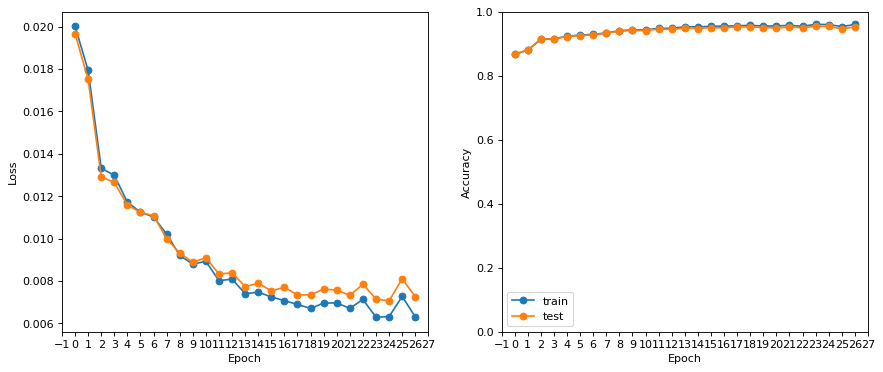

In [0]:
plot_loss_acc_by_epoch(*q3p2_losses)